In [1]:
import pandas as pd

df = pd.read_csv('USvideos.csv', encoding='latin1')  
print(df.columns)
print(df.head())


Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description'],
      dtype='object')
      video_id trending_date  \
0  2kyS6SvSYSE      17.14.11   
1  1ZAPwfrtAFY      17.14.11   
2  5qpjK5DgCt4      17.14.11   
3  puqaWrEC7tY      17.14.11   
4  d380meD0W0M      17.14.11   

                                               title          channel_title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE           CaseyNeistat   
1  The Trump Presidency: Last Week Tonight with J...        LastWeekTonight   
2  Racist Superman | Rudy Mancuso, King Bach & Le...           Rudy Mancuso   
3                   Nickelback Lyrics: Real or Fake?  Good Mythical Morning   
4                           I Dare You: GOING BALD!?               nigahiga   

   category_id              publish_time

In [2]:
print(df.columns.tolist())


['video_id', 'trending_date', 'title', 'channel_title', 'category_id', 'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count', 'thumbnail_link', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed', 'description']


In [3]:
df = df[['video_id', 'title', 'tags', 'views', 'likes', 'comment_count', 'thumbnail_link']]
df.dropna(inplace=True)


In [4]:
#df['is_viral'] = df['likes'] > 10000
df['is_viral'] = (df['likes'] > 10000) & (df['views'] > 1_000_000)


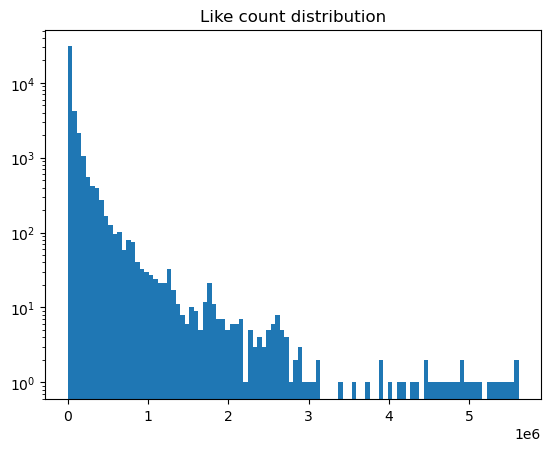

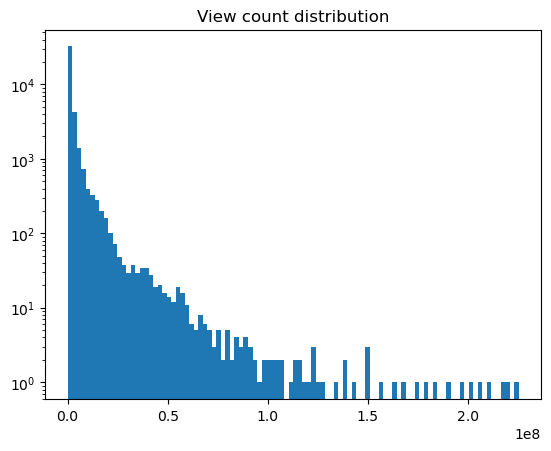

In [5]:
import matplotlib.pyplot as plt

plt.hist(df['likes'], bins=100, log=True)
plt.title("Like count distribution")
plt.show()

plt.hist(df['views'], bins=100, log=True)
plt.title("View count distribution")
plt.show()


In [6]:
pip install torch torchvision


Note: you may need to restart the kernel to use updated packages.


In [7]:
# =============================
# Just Kaggle small dataset 
# =============================
# def of（viral） 
df['is_viral'] = (df['likes'] > 10000) & (df['views'] > 1_000_000)

# =============================
# the tumbnail column in csv(pic)
# =============================
import os
import requests

os.makedirs('thumbnails', exist_ok=True)

def download_thumbnail(row):
    video_id = row['video_id']
    url = row['thumbnail_link']
    path = f'thumbnails/{video_id}.jpg'
    if not os.path.exists(path):
        try:
            r = requests.get(url, timeout=10)
            with open(path, 'wb') as f:
                f.write(r.content)
            print(f'Downloaded: {video_id}')
        except Exception as e:
            print(f'Failed: {video_id} - {e}')

df.head(100).apply(download_thumbnail, axis=1)  # 

# =============================
# get vec
# =============================
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet18(pretrained=True)
resnet.fc = torch.nn.Identity()  #
resnet = resnet.to(device)
resnet.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def extract_image_feature(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            features = resnet(img_tensor)
        return features.squeeze().cpu().numpy()
    except:
        return None

features = []
for vid in tqdm(df['video_id'].head(100)):
    path = f'thumbnails/{vid}.jpg'
    if os.path.exists(path):
        vec = extract_image_feature(path)
    else:
        vec = None
    features.append(vec)

df = df.head(100).copy()
df['image_feature'] = features
df = df[df['image_feature'].notnull()]  # del null

# =============================
# stand
# =============================
from sklearn.preprocessing import StandardScaler

X_num = df[['views', 'likes', 'comment_count']]
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

X_img = np.vstack(df['image_feature'].values)
X = np.hstack([X_img, X_num_scaled])
y = df['is_viral'].astype(int).values

# =============================
# log reg
# =============================
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 68.93it/s]


              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.40      0.40      0.40         5

    accuracy                           0.70        20
   macro avg       0.60      0.60      0.60        20
weighted avg       0.70      0.70      0.70        20



In [8]:

import torch.nn as nn

class MixedMLP(nn.Module):
    def __init__(self, input_dim=515):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()  # use sigmoid for this one
        )

    def forward(self, x):
        return self.net(x)
import torch
from torch.utils.data import TensorDataset, DataLoader

# just the pipeline
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

# loss opt 
model = MixedMLP(input_dim=X.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#train
for epoch in range(10):
    model.train()
    total_loss = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

model.eval()
with torch.no_grad():
    pred = model(X_tensor.to(device)).cpu().numpy()
    pred_class = (pred > 0.5).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y, pred_class))

Epoch 1, Loss: 4.2017
Epoch 2, Loss: 3.4034
Epoch 3, Loss: 3.1553
Epoch 4, Loss: 3.0369
Epoch 5, Loss: 3.2273
Epoch 6, Loss: 2.6965
Epoch 7, Loss: 2.4100
Epoch 8, Loss: 2.0311
Epoch 9, Loss: 2.9327
Epoch 10, Loss: 2.3928
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        77
           1       1.00      0.52      0.69        23

    accuracy                           0.89       100
   macro avg       0.94      0.76      0.81       100
weighted avg       0.90      0.89      0.88       100



In [9]:
print(df.columns.tolist())


['video_id', 'title', 'tags', 'views', 'likes', 'comment_count', 'thumbnail_link', 'is_viral', 'image_feature']


In [10]:
# text, thumbnail, length, 

In [11]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn


X_img = np.vstack(df['image_feature'].values)  


titles = df['title'].tolist()
tfidf = TfidfVectorizer(max_features=300, min_df=2, max_df=0.8)
X_text = tfidf.fit_transform(titles).toarray()   # shape=(n_samples,300)


X = np.hstack([X_img, X_text])                  # shape=(n_samples, 812)
y = df['is_viral'].astype(int).values           # shape=(n_samples,)


X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y.reshape(-1,1), dtype=torch.float32)
dataset  = TensorDataset(X_tensor, y_tensor)
loader   = DataLoader(dataset, batch_size=16, shuffle=True)


class MixedMLP(nn.Module):
    def __init__(self, input_dim=812):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = MixedMLP(input_dim=X.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


for epoch in range(10):
    model.train()
    total_loss = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        loss   = criterion(model(xb), yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(loader):.4f}")


model.eval()
with torch.no_grad():
    pred_prob  = model(X_tensor.to(device)).cpu().numpy()
    pred_class = (pred_prob > 0.5).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y, pred_class))



Epoch 1, Loss: 0.5927
Epoch 2, Loss: 0.5086
Epoch 3, Loss: 0.5195
Epoch 4, Loss: 0.4678
Epoch 5, Loss: 0.4338
Epoch 6, Loss: 0.3935
Epoch 7, Loss: 0.4140
Epoch 8, Loss: 0.3416
Epoch 9, Loss: 0.2734
Epoch 10, Loss: 0.3209
              precision    recall  f1-score   support

           0       0.94      0.97      0.96        77
           1       0.90      0.78      0.84        23

    accuracy                           0.93       100
   macro avg       0.92      0.88      0.90       100
weighted avg       0.93      0.93      0.93       100



In [12]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm

#    df['image_feature']  (n_samples,512)
#    df['title']         
#    df['is_viral']       0/1

# —— 2. title feature
titles = df['title'].tolist()
tfidf = TfidfVectorizer(max_features=300, min_df=2, max_df=0.8)
X_text = tfidf.fit_transform(titles).toarray()  # (n,300)

# —— 3. image
X_img = np.vstack(df['image_feature'].values)   # (n,512)

# —— 4. vec
X_all = np.hstack([X_img, X_text])              # (n,812)
y_all = df['is_viral'].astype(int).values       # (n,)

# —— 5.tt split
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all
)

# —— 6. PyTorch TensorDataset & DataLoader
def make_loader(X, y, batch_size=16, shuffle=True):
    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y.reshape(-1,1), dtype=torch.float32)
    ds  = TensorDataset(X_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = make_loader(X_train, y_train, batch_size=32, shuffle=True)
test_loader  = make_loader(X_test,  y_test,  batch_size=32, shuffle=False)

# —— 7.  MixedMLP
class MixedMLP(nn.Module):
    def __init__(self, input_dim=812):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = MixedMLP(input_dim=X_all.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# —— 8. traun
epochs = 10
for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred   = model(xb)
        loss   = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}/{epochs}  Train Loss: {total_loss/len(train_loader):.4f}")

# —— 9. valid
model.eval()
all_preds = []
all_labels= []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(yb.numpy())

all_preds = np.vstack(all_preds)
all_labels= np.vstack(all_labels)

pred_classes = (all_preds > 0.5).astype(int)

print("Test Classification Report:")
print(classification_report(all_labels, pred_classes, digits=4))


Epoch 1/10  Train Loss: 0.5705
Epoch 2/10  Train Loss: 0.4902
Epoch 3/10  Train Loss: 0.4858
Epoch 4/10  Train Loss: 0.4921
Epoch 5/10  Train Loss: 0.4373
Epoch 6/10  Train Loss: 0.4272
Epoch 7/10  Train Loss: 0.4234
Epoch 8/10  Train Loss: 0.3659
Epoch 9/10  Train Loss: 0.3387
Epoch 10/10  Train Loss: 0.2873
Test Classification Report:
              precision    recall  f1-score   support

         0.0     0.7500    1.0000    0.8571        15
         1.0     0.0000    0.0000    0.0000         5

    accuracy                         0.7500        20
   macro avg     0.3750    0.5000    0.4286        20
weighted avg     0.5625    0.7500    0.6429        20



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
import os
import numpy as np
import pandas as pd
import requests
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

from torchvision import models, transforms
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# ===========================
# 1.read
df = pd.read_csv('USvideos.csv', encoding='latin1')

#  viral standard 
df['is_viral'] = ((df['views'] > 1_000_000) & (df['likes'] > 10_000)).astype(int)

# 
# 2. image

os.makedirs('thumbnails', exist_ok=True)

def download_thumb(video_id, url):
    path = f"thumbnails/{video_id}.jpg"
    if not os.path.exists(path):
        try:
            r = requests.get(url, timeout=5)
            r.raise_for_status()
            with open(path, 'wb') as f:
                f.write(r.content)
        except Exception:
            return None
    return path

#
thumb_paths = []
for vid, url in tqdm(zip(df['video_id'], df['thumbnail_link']), 
                     total=len(df), desc="Downloading thumbs"):
    thumb_paths.append(download_thumb(vid, url))
df['thumbnail_path'] = thumb_paths
df = df[df['thumbnail_path'].notna()].reset_index(drop=True)

# 
# 3. image

#I use mac book
#for the big one use my roommate's cuda

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Identity()      # 
resnet.to(device).eval()

img_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

def extract_img_feat(path):
    try:
        img = Image.open(path).convert('RGB')
        t   = img_tf(img).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = resnet(t)
        return feat.squeeze().cpu().numpy()
    except:
        return None

img_feats = []
for p in tqdm(df['thumbnail_path'], desc="Extracting image features"):
    img_feats.append(extract_img_feat(p))
df['img_feat'] = img_feats
df = df[df['img_feat'].notnull()].reset_index(drop=True)

# 
# 4. text
# 
titles = df['title'].tolist()
tfidf = TfidfVectorizer(max_features=300, min_df=5, max_df=0.8)
X_text = tfidf.fit_transform(titles).toarray()  # (n,300)


# 5.vec

X_img = np.vstack(df['img_feat'].values)       # (n,512)
X_all = np.hstack([X_img, X_text])              # (n,812)
y_all = df['is_viral'].values                   # (n,)

# 6. ==tt split
X_tr, X_te, y_tr, y_te = train_test_split(
    X_all, y_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all
)


# 7. PyTorch Loader 

class_counts = np.bincount(y_tr)
weights_cls  = 1.0 / class_counts
sample_w     = weights_cls[y_tr]

sampler = WeightedRandomSampler(
    weights=sample_w,
    num_samples=len(sample_w),
    replacement=True
)

def make_loader(X, y, sampler=None):
    Xt = torch.tensor(X, dtype=torch.float32)
    yt = torch.tensor(y.reshape(-1,1), dtype=torch.float32)
    ds = TensorDataset(Xt, yt)
    return DataLoader(ds,
                      batch_size=32,
                      sampler=sampler,
                      shuffle=(sampler is None))

train_loader = make_loader(X_tr, y_tr, sampler=sampler)
test_loader  = make_loader(X_te, y_te, sampler=None)

# ===========================
# 8. MixedMLP
# ===========================
class MixedMLP(nn.Module):
    def __init__(self, input_dim=812):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)    # logit
        )
    def forward(self, x):
        return self.net(x)

model     = MixedMLP(input_dim=X_all.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(
    class_counts[0]/class_counts[1], device=device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ===========================
# 9. train
# ===========================
epochs = 10
for ep in range(1, epochs+1):
    model.train()
    running = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss   = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running += loss.item()
    print(f"Epoch {ep}/{epochs}  Train Loss: {running/len(train_loader):.4f}")

# ===========================
# 10.test

# ===========================
model.eval()
all_probs, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        probs  = torch.sigmoid(logits).cpu().numpy()
        all_probs.append(probs)
        all_labels.append(yb.numpy())

all_probs  = np.vstack(all_probs)
all_labels = np.vstack(all_labels)
preds      = (all_probs > 0.5).astype(int)

print(classification_report(all_labels, preds, digits=4))


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting image features: 100%|██████████| 37390/37390 [09:12<00:00, 67.63it/s]


Epoch 1/10  Train Loss: 0.8071
Epoch 2/10  Train Loss: 0.7147
Epoch 3/10  Train Loss: 0.6233
Epoch 4/10  Train Loss: 0.5561
Epoch 5/10  Train Loss: 0.5113
Epoch 6/10  Train Loss: 0.4809
Epoch 7/10  Train Loss: 0.4529
Epoch 8/10  Train Loss: 0.4213
Epoch 9/10  Train Loss: 0.4198
Epoch 10/10  Train Loss: 0.3860
              precision    recall  f1-score   support

         0.0     0.9539    0.8756    0.9131      4566
         1.0     0.8272    0.9337    0.8772      2912

    accuracy                         0.8982      7478
   macro avg     0.8906    0.9047    0.8952      7478
weighted avg     0.9046    0.8982    0.8991      7478



In [14]:
xb.shape

torch.Size([22, 812])

In [15]:
df['thumbnail_link'].iloc[0]
#df['title'].iloc[0]

'https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg'

In [16]:
xb[0][:512]

tensor([2.7987e-01, 6.6763e-01, 7.2772e-01, 1.3825e-01, 2.5842e-01, 3.5179e-01,
        4.1417e-01, 3.9617e-01, 2.3648e-01, 2.4252e-01, 3.5560e-01, 3.3000e-01,
        1.2872e+00, 2.0027e-01, 1.0485e-01, 5.1922e-01, 2.0923e+00, 5.2484e-01,
        2.7217e-01, 1.0182e-01, 5.4563e-01, 1.1566e-01, 2.5465e-01, 2.3196e+00,
        2.2537e-01, 6.2917e-03, 9.1561e-01, 1.1778e+00, 1.5968e-01, 1.5925e+00,
        2.1804e+00, 1.7272e-01, 4.8881e-01, 6.3441e-01, 1.3476e+00, 8.5540e-01,
        1.9800e+00, 7.8465e-01, 1.3257e+00, 2.6526e-01, 2.5009e-01, 2.4257e-01,
        4.5426e-02, 9.7351e-01, 1.2134e+00, 4.8228e-02, 9.6650e-01, 7.5331e-01,
        5.8663e-01, 5.7101e-01, 6.2128e-01, 1.9089e-01, 1.0144e+00, 2.0348e-01,
        1.0002e+00, 6.1561e-01, 3.7146e-01, 3.5425e-01, 8.8533e-01, 1.1362e+00,
        1.0667e-02, 2.5280e-02, 9.8593e-01, 1.1415e+00, 4.2982e-02, 4.1580e-01,
        5.6801e-01, 1.5082e-01, 7.3605e-01, 6.4164e-01, 5.2019e-01, 8.7903e-01,
        1.1732e-01, 5.1254e-01, 3.1671e-

In [45]:
def predict_viral(image_path, title_str, model, tfidf, img_tf, resnet, device, threshold=0.5):
    try:
        # image
        img = Image.open(image_path).convert('RGB')
        t = img_tf(img).unsqueeze(0).to(device)
        with torch.no_grad():
            img_vec = resnet(t).squeeze().cpu().numpy()  # (512,)
    except Exception as e:
        print(f"[ERROR] Image processing failed: {e}")
        return None

    try:
        # text
        text_vec = tfidf.transform([title_str]).toarray().squeeze()  # (300,)
    except Exception as e:
        print(f"[ERROR] Text vectorization failed: {e}")
        return None

    # 
    full_vec = np.hstack([img_vec, text_vec]).reshape(1, -1)  # (1, 812)
    xt = torch.tensor(full_vec, dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        logit = model(xt)
        prob = torch.sigmoid(logit).item()

    pred = int(prob > threshold)
    print(f"[Prediction] Viral Probability: {prob:.4f} → {'VIRAL ✅' if pred else 'Not Viral ❌'}")
    return prob, pred


In [67]:
title_str = "Mr Beast"
image_path = "mr_beast.jpg"

predict_viral(image_path, title_str, model, tfidf, img_tf, resnet, device)


[Prediction] Viral Probability: 0.0559 → Not Viral ❌


(0.05588740482926369, 0)

In [49]:
import os
os.listdir(".")


['mr_beast.jpg',
 'final model.ipynb',
 '.ipynb_checkpoints',
 'USvideos.csv',
 'thumbnails']

In [53]:
class FullModel(nn.Module):
    def __init__(self, tfidf_dim=300):
        super().__init__()
        # image
        resnet = models.resnet18(pretrained=True)
        resnet.fc = nn.Identity()
        self.resnet = resnet

        # text
        self.text_fc = nn.Sequential(
            nn.Linear(tfidf_dim, 128),
            nn.ReLU()
        )

        # MLP
        self.classifier = nn.Sequential(
            nn.Linear(512 + 128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  #  logit
        )

    def forward(self, image_tensor, text_tensor):
        """
        image_tensor: (B, 3, 224, 224)
        text_tensor: (B, 300)
        """
        img_feat = self.resnet(image_tensor)             # (B, 512)
        text_feat = self.text_fc(text_tensor)            # (B, 128)
        x = torch.cat([img_feat, text_feat], dim=1)      # (B, 640)
        return self.classifier(x)                        # (B, 1)


In [55]:
df = pd.read_csv("USvideos.csv", encoding="latin1", nrows=10000)


In [71]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# ========== 1. Load CSV ==========
df = pd.read_csv('USvideos.csv', encoding='latin1')
df = df.head(20000).copy()
df['is_viral'] = ((df['views'] > 1_000_000) & (df['likes'] > 10_000)).astype(int)

# ========== 2. Download Thumbnails ==========
os.makedirs('thumbnails', exist_ok=True)
def download_thumb(video_id, url):
    path = f"thumbnails/{video_id}.jpg"
    if not os.path.exists(path):
        try:
            r = requests.get(url, timeout=5)
            with open(path, 'wb') as f:
                f.write(r.content)
        except:
            return None
    return path

df['thumbnail_path'] = [download_thumb(vid, url) for vid, url in tqdm(zip(df['video_id'], df['thumbnail_link']), total=len(df))]
df = df[df['thumbnail_path'].notna()].reset_index(drop=True)

# ========== 3. TF-IDF ==========
tfidf = TfidfVectorizer(max_features=300, min_df=1, max_df=0.9)
X_text = tfidf.fit_transform(df['title']).toarray()

# ========== 4. Image Transform ==========
img_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ========== 5. Custom Dataset ==========
class FullDataset(Dataset):
    def __init__(self, df, X_text, transform):
        self.df = df.reset_index(drop=True)
        self.X_text = X_text
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Image
        path = self.df.loc[idx, 'thumbnail_path']
        image = Image.open(path).convert('RGB')
        image = self.transform(image)
        # Text
        text_feat = torch.tensor(self.X_text[idx], dtype=torch.float32)
        # Label
        label = torch.tensor(self.df.loc[idx, 'is_viral'], dtype=torch.float32).unsqueeze(0)
        return image, text_feat, label

# ========== 6. Model ==========
class FullModel(nn.Module):
    def __init__(self, tfidf_dim=300):
        super().__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.resnet.fc = nn.Identity()
        self.text_fc = nn.Sequential(
            nn.Linear(tfidf_dim, 128),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 + 128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, image_tensor, text_tensor):
        img_feat = self.resnet(image_tensor)
        text_feat = self.text_fc(text_tensor)
        x = torch.cat([img_feat, text_feat], dim=1)
        return self.classifier(x)

# ========== 7. Dataloaders ==========
device = torch.device("cpu")
dataset = FullDataset(df, X_text, img_tf)
y_all = df['is_viral'].values
X_train_idx, X_test_idx = train_test_split(
    np.arange(len(y_all)), test_size=0.2, stratify=y_all, random_state=42
)
train_ds = torch.utils.data.Subset(dataset, X_train_idx)
test_ds  = torch.utils.data.Subset(dataset, X_test_idx)

# Weighted sampler to balance
class_counts = np.bincount(y_all[X_train_idx])
weights_cls = 1.0 / class_counts
sample_w = weights_cls[y_all[X_train_idx]]
sampler = WeightedRandomSampler(weights=sample_w, num_samples=len(sample_w), replacement=True)

train_loader = DataLoader(train_ds, batch_size=16, sampler=sampler)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)

# ========== 8. Train ==========
model = FullModel(tfidf_dim=300).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(class_counts[0] / class_counts[1], device=device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, 6):
    model.train()
    total_loss = 0.0
    for img, txt, lbl in tqdm(train_loader, desc=f"Epoch {epoch}"):
        img, txt, lbl = img.to(device), txt.to(device), lbl.to(device)
        out = model(img, txt)
        loss = criterion(out, lbl)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Epoch {epoch}] Train Loss: {total_loss / len(train_loader):.4f}")

# ========== 9. Evaluate ==========
model.eval()
all_probs, all_labels = [], []
with torch.no_grad():
    for img, txt, lbl in test_loader:
        img, txt = img.to(device), txt.to(device)
        probs = torch.sigmoid(model(img, txt)).cpu().numpy()
        all_probs.append(probs)
        all_labels.append(lbl.numpy())

probs = np.vstack(all_probs)
labels = np.vstack(all_labels)
preds = (probs > 0.5).astype(int)

print(classification_report(labels, preds, digits=4))


Epoch 1:  32%|█████████▉                     | 319/1000 [05:20<11:25,  1.01s/it]


KeyboardInterrupt: 